___
# Classification of ED triage notes for self-harm
___

In [1]:
import pandas as pd
from scipy.stats import uniform

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import make_pipeline

import pickle

# Project imports
from self_harm_triage_notes.config import *
from self_harm_triage_notes.dev_utils import get_stopwords

# Toolbox imports
from ml_health_toolbox.dev_utils import *
from ml_health_toolbox.eval_utils import *

In [2]:
# Suppress warnings (including in worker processes started via spawn)
import os
# Ensure child processes inherit this setting
os.environ['PYTHONWARNINGS'] = 'ignore'

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set-up
# Development data
dev_data_filename = "rmh_2012_2017_dev"

# Test data
test_data_filename = "rmh_2012_2017_test"

# Classification label and features
label = 'SH' #'SH_SI'
features = 'entities'
palette = ['#757F8D','#E15644']
    
# Undersampling
undersample = False
n_controls = 10000

# Dimensionality reduction
reduce_dim = False
lsa_method = 'svd'
n_components = 100

# Additional features
add_length = False
add_metadata = False

___
## Data preparation

In [4]:
# Load the development set
df = pd.read_parquet(proc_data_dir / (dev_data_filename + "_normalised.parquet"), engine="pyarrow")

# Keep data up to 2017 for development
df = df[df.year <= 2017].copy()

# Rename label column
df.rename(columns={label: 'y'}, inplace=True)

# Class names
classes = df.y.cat.categories

# Define features and labels
X = df[features]
y = df.y
groups = df.uid

# Define CV strategy
cv = get_cv_strategy(groups=groups, n_splits=N_SPLITS)

# Dictionary to store metrics
metrics_dict = {}

df.y.value_counts(normalize=True).sort_index().round(4)*100

y
Not self-harm    98.65
Self-harm         1.35
Name: proportion, dtype: float64

In [ ]:
# (Archived)
# from ml_health_toolbox.dataset_utils import to_categorical

# df["SH_SI"] = np.where((df.SH.cat.codes==1)|(df.SI.cat.codes==1), "Positive", "Negative")
# df.SH_SI = to_categorical(df.SH_SI, categories=["Negative", "Positive"])

# df.SH_SI.value_counts()

# # Concatenate with sex,age,arrival mode
# if add_metadata:
#     df[features] = df.apply(lambda x: " ".join(x[['concepts', 'sex', 
#                                                   'age','arrival_mode']].astype(str)), axis=1)
    
# # Perform undersampling
# if undersample:
#     df = pd.concat([df[df.SH == 0].sample(n_controls, random_state=42), 
#                     df[df.SH!=0]], axis=0)

___
# Model development

### Quick & dirty trying a few algorithms

In [ ]:
vectorizer = TfidfVectorizer(stop_words=get_stopwords(), token_pattern=r'\S+')
selector = SelectPercentile(score_func=chi2, percentile=5)

clfs = (
    MultinomialNB(),
    LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', random_state=42),
#     RandomForestClassifier(class_weight="balanced", random_state=42),
#     GradientBoostingClassifier(random_state=42),
#     XGBClassifier(objective='binary:logistic', random_state=42),
    LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1),
)

for clf in clfs:
    pipeline = make_pipeline(vectorizer, selector, clf)
    score_cv(pipeline, X, y.cat.codes, groups, len(y.cat.categories), cv=cv)

### Proper model comparison with nested CV 

In [ ]:
pipelines = []
search_modes = []
param_grids = []

vectorizer = TfidfVectorizer(stop_words=get_stopwords(), token_pattern=r'\S+')
selector = SelectPercentile(score_func=chi2)

# # MNB
# clf = MultinomialNB()
# pipeline = make_pipeline(vectorizer, selector, clf)
# pipelines.append(pipeline)

# search_modes.append('random')

# param_grid = {
#     'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2)), 
#     'tfidfvectorizer__max_df': (0.8, 0.9, 1.0),
#     'tfidfvectorizer__min_df': (10, 20),
#     'tfidfvectorizer__sublinear_tf': (True, False),
#     'selectpercentile__percentile': (0.1, 0.5, 1, 5),
#     'multinomialnb__alpha': (1e-5, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 50, 100),
#     }
# param_grids.append(param_grid)

# # Logistic Regression
# clf = LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', random_state=42)
# pipeline = make_pipeline(vectorizer, selector,clf)
# pipelines.append(pipeline)

# search_modes.append('random')

# param_grid = {
#     'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2)), 
#     'tfidfvectorizer__max_df': (0.8, 0.9, 1.0),
#     'tfidfvectorizer__min_df': (10, 20),
#     'tfidfvectorizer__sublinear_tf': (True, False),
#     'selectpercentile__percentile': (0.1, 0.5, 1, 5),
#     'logisticregression__C': (1e-5, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 50, 100),
#     'logisticregression__l1_ratio': (1.0, 0.75, 0.5, 0.25, 0.0),
#     }
# param_grids.append(param_grid)

# LightGBM
clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
pipeline = make_pipeline(vectorizer, selector, clf)
pipelines.append(pipeline)

search_modes.append('random')

num_leaves = [5, 10, 30, 50, 100]
max_depth = [-1, 3, 4, 5, 6, 7, 10]
learning_rate = [0.01, 0.1, 0.25]
n_estimators = [300, 350, 400, 450, 500]
min_child_samples = range(1, 50)
subsample = uniform(0.1, 1.0)
colsample_bytree = uniform(0.1, 1.0) 
reg_alpha = uniform(0.0, 1.0)
reg_lambda = uniform(0.0, 1.0)

param_grid = {
    'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2)), 
    'tfidfvectorizer__max_df': (0.8, 0.9, 1.0),
    'tfidfvectorizer__min_df': (10, 20),
    'tfidfvectorizer__sublinear_tf': (True, False),
    'selectpercentile__percentile': (0.1, 0.5, 1, 5),
    'lgbmclassifier__num_leaves': num_leaves,
    'lgbmclassifier__max_depth': max_depth,
    'lgbmclassifier__learning_rate': learning_rate,
    'lgbmclassifier__n_estimators': n_estimators,
    'lgbmclassifier__min_child_samples': min_child_samples,
    'lgbmclassifier__subsample': subsample,
    'lgbmclassifier__colsample_bytree': colsample_bytree,
    'lgbmclassifier__reg_alpha': reg_alpha,
    'lgbmclassifier__reg_lambda': reg_lambda,
}
param_grids.append(param_grid)

In [ ]:
for pipeline, search_mode, param_grid in zip(pipelines, search_modes, param_grids):
        benchmark_nested_cv(pipeline, search_mode, param_grid, X, y.cat.codes, groups, len(y.cat.categories), cv=cv)

### Tune the final model

In [ ]:
# LightGBM
vectorizer = TfidfVectorizer(stop_words=get_stopwords(), token_pattern=r'\S+')
selector = SelectPercentile(score_func=chi2)
clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
pipeline = make_pipeline(vectorizer, selector, clf)

num_leaves = [5, 10, 30, 50, 100]
max_depth = [-1, 3, 4, 5, 6, 7, 10]
learning_rate = [0.1]
n_estimators = [300, 400, 500]
min_child_samples = range(1, 50)
subsample = uniform(0.5, 1.0)
colsample_bytree = uniform(0.5, 1.0) 
reg_alpha = uniform(0.0, 1.0)
reg_lambda = uniform(0.0, 1.0)

param_grid = {
    'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2)), 
    'tfidfvectorizer__max_df': (0.8, 0.9, 1.0),
    'tfidfvectorizer__min_df': (10, 20),
    'tfidfvectorizer__sublinear_tf': (True, False),
    'selectpercentile__percentile': uniform(0.1, 15.0),
    'lgbmclassifier__num_leaves': num_leaves,
    'lgbmclassifier__max_depth': max_depth,
    'lgbmclassifier__learning_rate': learning_rate,
    'lgbmclassifier__n_estimators': n_estimators,
    'lgbmclassifier__min_child_samples': min_child_samples,
    'lgbmclassifier__subsample': subsample,
    'lgbmclassifier__colsample_bytree': colsample_bytree,
    'lgbmclassifier__reg_alpha': reg_alpha,
    'lgbmclassifier__reg_lambda': reg_lambda,
    'lgbmclassifier__is_unbalance': [True, False],
}

search_result = search_params(pipeline, 'random', param_grid, X, y.cat.codes, groups, cv=cv, scoring='average_precision')
tuned_model = search_result.best_estimator_

>**Optimising for _neg_log_loss_**
>
>Best for current fold: -0.026 using {'lgbmclassifier__colsample_bytree': 0.5527116054016623, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': -1, 'lgbmclassifier__min_child_samples': 6, 'lgbmclassifier__n_estimators': 500, 'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__reg_alpha': 0.1537256479464325, 'lgbmclassifier__reg_lambda': 0.565508645324995, 'lgbmclassifier__subsample': 0.8801220034308666, 'selectpercentile__percentile': 5, 'tfidfvectorizer__max_df': 0.8, 'tfidfvectorizer__min_df': 20, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__sublinear_tf': False}
>
>**Optimising for _average_precision_**
>
>Best for current fold: 0.832 using {'lgbmclassifier__colsample_bytree': 0.6233363698626688, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': -1, 'lgbmclassifier__min_child_samples': 11, 'lgbmclassifier__n_estimators': 400, 'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__reg_alpha': 0.5957178236909818, 'lgbmclassifier__reg_lambda': 0.6892101968116234, 'lgbmclassifier__subsample': 0.3645831341837288, 'selectpercentile__percentile': 5, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__sublinear_tf': False}
>
> **Optimising for _average_precision_, original tokenizer settings, _is_unbalance=False_, allowing n_grams**
>
>Best for current fold: 0.850 using {'lgbmclassifier__colsample_bytree': 0.7101410610866284, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 6, 'lgbmclassifier__min_child_samples': 4, 'lgbmclassifier__n_estimators': 500, 'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__reg_alpha': 0.778976006508152, 'lgbmclassifier__reg_lambda': 0.5801504076624308, 'lgbmclassifier__subsample': 0.812912541609473, 'selectpercentile__percentile': 1.9840691514980384, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__sublinear_tf': True}
>
> **Optimising for _average_precision_, original tokenizer settings, _is_unbalance=False_, n_grams=(1,1)**
>
>Best for current fold: 0.841 using {'lgbmclassifier__colsample_bytree': 0.5706749336718006, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 6, 'lgbmclassifier__min_child_samples': 32, 'lgbmclassifier__n_estimators': 500, 'lgbmclassifier__num_leaves': 100, 'lgbmclassifier__reg_alpha': 0.07717445387366473, 'lgbmclassifier__reg_lambda': 0.6269069237699412, 'lgbmclassifier__subsample': 0.6920048115805094, 'selectpercentile__percentile': 2.929910691833551, 'tfidfvectorizer__max_df': 0.8, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__sublinear_tf': True}
>
> **Optimising for _average_precision_, original tokenizer settings, _is_unbalance=False_, allowing n_grams, max percentile=15**
>
>Best for current fold: 0.852 using {'lgbmclassifier__colsample_bytree': 0.5019931848832546, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 7, 'lgbmclassifier__min_child_samples': 28, 'lgbmclassifier__n_estimators': 400, 'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__reg_alpha': 0.046332229238282174, 'lgbmclassifier__reg_lambda': 0.4293800090383446, 'lgbmclassifier__subsample': 0.9020520654144291, 'selectpercentile__percentile': 10.810376238921988, 'tfidfvectorizer__max_df': 0.8, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__sublinear_tf': False}





### Tuned model

In [5]:
# 100% dev data, percentile up to 3%
vectorizer = TfidfVectorizer(stop_words=get_stopwords(), token_pattern=r'\S+')
selector = SelectPercentile(score_func=chi2)
clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
pipeline = make_pipeline(vectorizer, selector, clf)
params = {'lgbmclassifier__colsample_bytree': 0.7101410610866284, 
          'lgbmclassifier__learning_rate': 0.1, 
          'lgbmclassifier__max_depth': 6, 
          'lgbmclassifier__min_child_samples': 4, 
          'lgbmclassifier__n_estimators': 500, 
          'lgbmclassifier__num_leaves': 50, 
          'lgbmclassifier__reg_alpha': 0.778976006508152, 
          'lgbmclassifier__reg_lambda': 0.5801504076624308, 
          'lgbmclassifier__subsample': 0.812912541609473, 
          'selectpercentile__percentile': 1.9840691514980384, 
          'tfidfvectorizer__max_df': 0.9, 
          'tfidfvectorizer__min_df': 10, 
          'tfidfvectorizer__ngram_range': (1, 3), 
          'tfidfvectorizer__sublinear_tf': True}
tuned_model = pipeline.set_params(**params)

# # 100% dev data, percentile up to 15%
# vectorizer = TfidfVectorizer(stop_words=get_stopwords(), token_pattern=r'\S+')
# selector = SelectPercentile(score_func=chi2)
# clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
# pipeline = make_pipeline(vectorizer, selector, clf)
# params = {'lgbmclassifier__colsample_bytree': 0.5019931848832546,
#           'lgbmclassifier__learning_rate': 0.1,
#           'lgbmclassifier__max_depth': 7,
#           'lgbmclassifier__min_child_samples': 28,
#           'lgbmclassifier__n_estimators': 400,
#           'lgbmclassifier__num_leaves': 50,
#           'lgbmclassifier__reg_alpha': 0.046332229238282174,
#           'lgbmclassifier__reg_lambda': 0.4293800090383446,
#           'lgbmclassifier__subsample': 0.9020520654144291,
#           'selectpercentile__percentile': 10.810376238921988, 
#           'tfidfvectorizer__max_df': 0.8, 
#           'tfidfvectorizer__min_df': 10, 
#           'tfidfvectorizer__ngram_range': (1, 3), 
#           'tfidfvectorizer__sublinear_tf': False}
# tuned_model = pipeline.set_params(**params)

 ### Evaluate the tuned model

In [6]:
# Calculate performance scores
score_cv(tuned_model, X, y.cat.codes, groups, len(y.cat.categories), cv=cv)

# Make predictions for each CV fold
y_proba = predict_cv(tuned_model, X, y.cat.codes, groups, cv=cv)

________________________________________________________________________________
Training with 5-fold cross-validation:
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 3),
                                 stop_words=['a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway...
                 SelectPercentile(percentile=1.9840691514980384,
                 

### Calibrate the tuned model

* uncalibrated -- second best
* calibrated with isotonic and ensemble=True -- best, three models ~1350 fts each (FN=1016>253, FP=727>188)
* calibrated with isotonic and ensemble=False -- worst

In [7]:
# Calibrate the model
tuned_model_calibrated, y_proba_calibrated = calibrate_cv(tuned_model, X, y, groups, cv=cv, method='isotonic', ensemble=True)

________________________________________________________________________________
Training with 5-fold cross-validation:
CalibratedClassifierCV(cv=3, ensemble=True,
                       estimator=Pipeline(steps=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
               

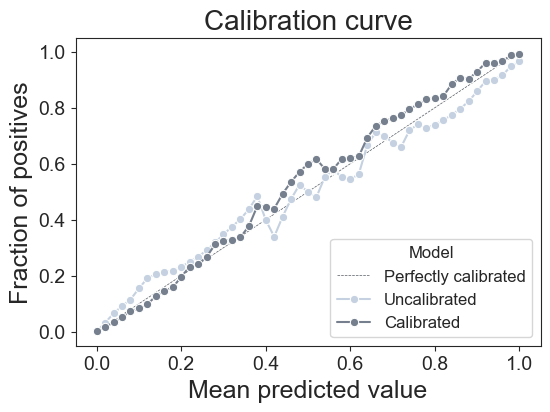

In [8]:
# Calculate calibration curves for the uncalibrated and calibrated versions of the model
calibration_curves = prepare_calibration_curve(y, y_proba, y_proba_calibrated)
# Plot calibration curves to compare the uncalibrate and calibrated vesions of the model
plot_calibration_curve(calibration_curves, palette=['#C5D1E0', '#757F8D'], results_dir=results_dir, filename=dev_data_filename + "comparison")

### Select the best model

In [9]:
# Use the uncalibrated or calibrated version
best_model = tuned_model_calibrated
y_proba = y_proba_calibrated

### Estimate model discrimination

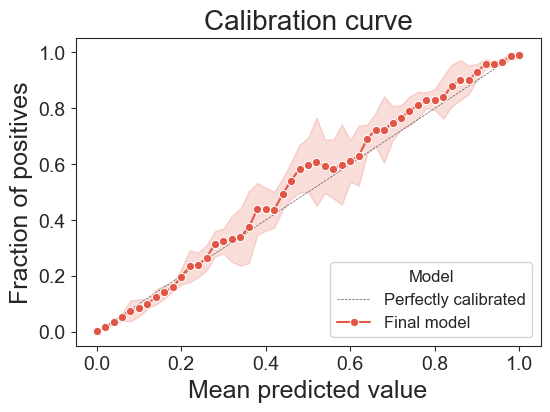

In [10]:
# Calculate calibration curves for CV folds
cv_generator = cv.split(X, y.cat.codes, groups)
calibration_curves = prepare_calibration_curve(y, y_proba, generator=cv_generator)
# Plot calibration curves for CV folds
plot_calibration_curve(calibration_curves, palette=palette[1:], results_dir=results_dir, filename=dev_data_filename + " CV")

In [11]:
# Define curves to calculate
curves_to_calculate = [
        {
        'name': 'ROC AUC', 
        'func': calculate_roc_curve_coords,
        'binary_filter': True,
        },
        {
        'name': 'PR AUC', 
        'func': calculate_pr_curve_coords,
        'binary_filter': False,
        },
    ]

# Calculate discrimination metrics for each CV fold
cv_generator = cv.split(X, y.cat.codes, groups)
curve_coords = calculate_curve_coords(y, y_proba, curves_to_calculate, generator=cv_generator)

In [12]:
# Calculate discrimination metrics per class
calculate_stats(calculate_auc_from_coords(curve_coords)).round(2)

,class_,metric,mean,std
0,Not self-harm,PR AUC,1.00,0.00
1,Not self-harm,ROC AUC,NaN,NaN
2,Self-harm,PR AUC,0.85,0.01
3,Self-harm,ROC AUC,0.99,0.00


In [13]:
# Calculate macro-averaged discrimination metrics
calculate_stats(calculate_auc_from_coords(curve_coords), macro_average=True)

,metric,mean,std
0,PR AUC,0.926397,0.005076
1,ROC AUC,0.987308,0.001587


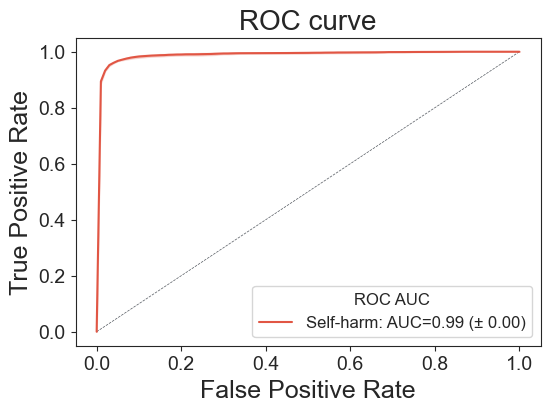

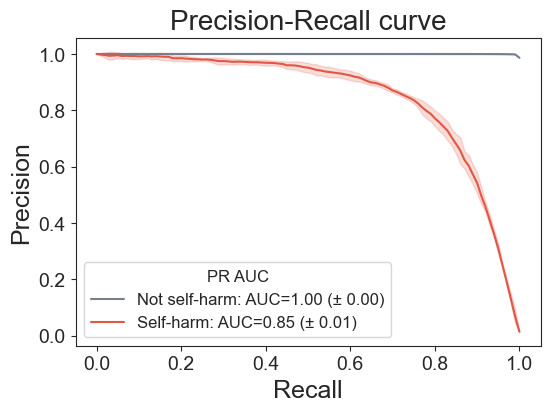

In [14]:
# Plot ROC curves for CV folds
plot_roc_curve(curve_coords[curve_coords.metric == 'ROC AUC'], palette=palette[1:], results_dir=results_dir, filename=dev_data_filename + " CV")
# Plot PR curves for CV folds
plot_pr_curve(curve_coords[curve_coords.metric == 'PR AUC'], palette=palette, results_dir=results_dir, filename=dev_data_filename + " CV")

### Estimate model classification

In [15]:
# Find an optimal threshold and make predictions for each CV fold
y_pred = np.zeros_like(y.cat.codes)
cv_generator = cv.split(X, y.cat.codes, groups)
for _, test_idx in cv_generator:
    threshold = calculate_optimal_threshold(y.cat.codes[test_idx], y_proba[test_idx,1])
    y_pred[test_idx] = probability_to_label(y_proba[test_idx], threshold=threshold-0.05)

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.341, F1-score = 0.804

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.322, F1-score = 0.803

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.444, F1-score = 0.784

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.363, F1-score = 0.797

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.392, F1-score = 0.794



In [16]:
classification_metrics = [
        {
        'name': 'precision', 
        'func': calculate_precision_score,
        },
        {
        'name': 'recall', 
        'func': calculate_recall_score,
        },
    ]
cv_generator = cv.split(X, y.cat.codes, groups)
scores = calculate_classification_metrics(y, y_pred, classification_metrics, generator=cv_generator)

In [17]:
# Calculate classification metrics per class
calculate_stats(scores).round(2)

,class_,metric,mean,std
0,Not self-harm,precision,1.00,0.00
1,Not self-harm,recall,1.00,0.00
2,Self-harm,precision,0.79,0.01
3,Self-harm,recall,0.79,0.02


In [18]:
# Calculate macro-averaged discrimination metrics
calculate_stats(scores, macro_average=True)

,metric,mean,std
0,precision,0.893506,0.004402
1,recall,0.893375,0.010502


### Select the optimal probability threshold

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.341, F1-score = 0.804

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.322, F1-score = 0.803

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.444, F1-score = 0.784

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.363, F1-score = 0.797

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.392, F1-score = 0.794

Average optimal threshold: 0.372 (+/- 0.04)


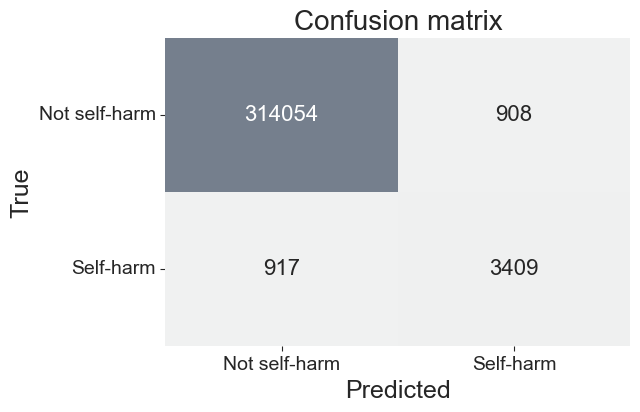

In [19]:
# Convert probabilities to crisp class labels
if len(y.cat.categories)==2:
     # Find an optimal threshold for each CV fold
    cv_generator = cv.split(X, y.cat.codes, groups)
    threshold = select_threshold(y.cat.codes, y_proba[:,1], cv_generator) - 0.05

    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba, threshold=threshold)
else:
    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba)

# Plot confusion matrix
plot_confusion_matrix(y, y_pred, color=palette[0])

### Re-train the final model on the full development set

In [20]:
# Re-train the final model on the full development set
best_model.fit(X, y.cat.codes)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...verbose=-1))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",-1
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",True
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are giv

### Export selected features

In [21]:
# Uncalibrated
# best_model[1].get_support().sum()
# Calibrated ensemble=False
# best_model.calibrated_classifiers_[0].estimator[1].get_support().sum()
# Calibrated ensemble=True
# best_model.calibrated_classifiers_[0].estimator[1].get_support().sum(), best_model.calibrated_classifiers_[1].estimator[1].get_support().sum(), best_model.calibrated_classifiers_[2].estimator[1].get_support().sum()
# for i in range(3):
    # print(f"Calibrated ensemble={i}: {len(best_model.calibrated_classifiers_[i].estimator[0].get_feature_names_out()), best_model.calibrated_classifiers_[i].estimator[1].get_support().sum()}")

In [22]:
all_selected_fts = []
for i in range(3):
    input_fts = best_model.calibrated_classifiers_[i].estimator[0].get_feature_names_out()
    masked_fts = best_model.calibrated_classifiers_[i].estimator[1].get_support()
    selected_fts = input_fts[masked_fts]
    print(f"Selected features for fold {i+1}: {len(selected_fts)}")
    # with open(models_dir / (dev_data_filename + "_" + label + "_REFIT_ensemble_True_selected_fts" + str(i) + ".txt"), 'w') as f:
    #     f.write("\n".join(selected_fts)) 
    all_selected_fts.extend(input_fts[masked_fts])
print(f"Total unique selected features across all folds: {len(set(all_selected_fts))}")
# with open(models_dir / (dev_data_filename + "_" + label + "_REFIT_ensemble_True_selected_fts_all.txt"), 'w') as f:
#         f.write("\n".join(sorted(set(all_selected_fts))))

Selected features for fold 1: 1355
Selected features for fold 2: 1347
Selected features for fold 3: 1315
Total unique selected features across all folds: 1931


### Overfitting: feature selection vs. classifier

In [23]:
# # Fit vectorizer to the full development set
# vectorizer = get_vectorizer(vectorizer_mode, params)
# vectorizer.fit(X,y)
# print("Vectorizer selected %d features." % vectorizer.df_features.shape[0])

# # Save the vectorizer
# with open(models_dir / (dev_data_filename + "_vectorizer.pickle"), 'wb') as f:
#     pickle.dump(vectorizer, f)
 
# # List selected features
# selected_features = vectorizer.df_features.feature.tolist() #vectorizer.vectorizer.get_feature_names_out()
# print(len(selected_features))

# # Write the list of selected features
# with open(models_dir / (dev_data_filename + "_selected_fts.txt"), 'w') as f:
#     f.writelines('\n'.join(selected_features))

___
# Save the final model and the threshold value

In [24]:
# Save the model
with open(models_dir / (dev_data_filename + "_" + label + "_REFIT_ensemble_True_classifier.pickle"), 'wb') as f:
    pickle.dump(best_model, f)
    
if len(df.y.cat.categories)==2:
    # Save the threshold
    with open(models_dir / (dev_data_filename + "_" + label + "_REFIT_ensemble_True_threshold.txt"), 'w') as f:
        f.write(str(threshold)) 

In [ ]:
# with open(models_dir / (dev_data_filename + "_" + label + "_REFIT_metrics.txt"), 'w') as f:
#         f.write(str(metrics_dict)) 